### Import & Preprocessing

In [2]:
import pandas as pd
import random
import re
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [32]:
def calculate_ttr(text):
    # Tokenize the text by splitting on non-alphabetic characters and converting to lowercase
    text = str(text)
    tokens = re.findall(r'\b\w+\b', text.lower())  # Tokenize and ignore case
    types = set(tokens)  # Unique words
    num_tokens = len(tokens)
    num_types = len(types)
    
    # Calculate TTR
    return num_types / num_tokens if num_tokens > 0 else 0

def isStudent(profession):
    isStudent = False
    if type(profession) == str:
        isStudent = profession in ['Undergraduate_Student', 'Graduate_Student']
    elif type(profession) == int:
        isStudent = profession == 2 or profession == 3
    if isStudent:
        return 1
    else:
        return 0
    
def bug_report_metrics(dataX, dataY, predictions, bug_report_column):
    bug_report_metrics = {}
    overall_precision, overall_recall, _, _ = score(dataY, predictions, average='binary')
    bug_report_metrics["overall"] = {"precision": overall_precision, "recall": overall_recall}
    for bug_report in dataX[bug_report_column].unique():
        # Filter both y and predictions for the specific bug report
        mask = dataX[bug_report_column] == bug_report
        report_precision, report_recall, _, _ = score(dataY[mask], predictions[mask], average='binary')
        bug_report_metrics[bug_report] = {"precision": report_precision, "recall": report_recall}
    return bug_report_metrics

def print_bug_report_metrics(bug_report_metrics, title, verbose=True):
    if verbose:
        print("-" * 40)
        print("'" + title + "' Metrics per Bug Report:")
        for bug_report, metrics in bug_report_metrics.items():
            print(f"{bug_report}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}")
    else:
        print("'" + title + "' Metrics Overall: Precision={:.2f}, Recall={:.2f}".format(bug_report_metrics["overall"]["precision"], bug_report_metrics["overall"]["recall"]))

def print_iteration_number_at_threshold(iteration_number_at_threshold):
    print("-"*40)
    print(f"Number of 'Non-Students' added to the 'Student Holdout Set' before")
    for metric in iteration_number_at_threshold.keys():
        for threshold in iteration_number_at_threshold[metric].keys():
            if float(threshold) < 0 : 
                direction = "dropped below"
            else:
                direction = "increased above"
            print(f"{metric.capitalize()} "+direction+ f" {threshold}: {iteration_number_at_threshold[metric][threshold]}")

def print_iteration_number_within_threshold(iteration_number_at_threshold):
    print("-"*40)
    print(f"Number of 'Non-Students' added to the 'Student Training Set' before")
    for metric in iteration_number_at_threshold.keys():
        for threshold in iteration_number_at_threshold[metric].keys():
            print(f"{metric.capitalize()} is within {threshold} absolute difference to baseline: {iteration_number_at_threshold[metric][threshold]}")

### Task 1.1

We experimented with the data. We found that Task 1 is highly dependend on (1) the seed for random processes and (2) the specific methods chosen from the Failing Methods in the data set. 

To combat issue (2) we chose to randomly choose two failing methods (i.e. 'HIT01_8', 'HIT02_24') to include in our holdout sets. 

Issue (1) is harder to solve. By experimenting we identified that for most seeds there is no impact of 5% and 10% loss on precision and recall when adding more non-students to the holdout set. This makes answering the question task 1.1 poses more difficult. We hence perform the experiment for a range of seeds. Often times the precision and recall value does not fall below the thresholds regardless of how many non-students are added. This would mean that the average value would tend to infinity if even for one seed the threshold is not reached. This intuitively makes only little sense. We thus calculate the average in two ways: (I) by counting never reaching the threshold as instantly reaching the threshold and (II) just disregarding not reaching the threshold and only averaging the number of non-students added when reaching the threshold if a threshold is reached. For all thresholds we report both values. 

Furthermore, we calculate which seeds results in reaching all (i.e., 4) tresholds and which just reach 3 tresholds. We will work with these thresholds in task 1.2.

**Exercise 3. Task 1.1**

Gradually add at random “Non-Students” to the holdout set and report on the
degradation of the classifier’s precision and recall

In [5]:

verbose = False
balance = True
max_not_infinite = 3
threshold_sums = {"precision": {"-0.05": 0, "-0.1": 0}, "recall": {"-0.05": 0, "-0.1": 0}}
threshold_sums_cleaned = {"precision": {"-0.05": 0, "-0.1": 0}, "recall": {"-0.05": 0, "-0.1": 0}}
threshold_sums_cleaned_amount = {"precision": {"-0.05": 0, "-0.1": 0}, "recall": {"-0.05": 0, "-0.1": 0}}
seeds_reaching_number_thresholds ={0:[], 1:[], 2:[], 3:[], 4:[]}
safe_results_for_seeds = [28, 73, 100, 104, 166, 206, 211, 74]
saved_results = {}
for seed in tqdm.tqdm(range(0,250)):
    RANDOM_SEED = seed #27
    random.seed(RANDOM_SEED)

    # Data preparation
    data = pd.read_csv("../../data/answerList_data.csv")
    data['TTR'] = data['Answer.explanation'].apply(calculate_ttr)
    data['Worker.profession'] = data['Worker.profession'].map({'Other': 0, 'Hobbyist': 1, 'Undergraduate_Student': 2, 'Graduate_Student': 3, 'Professional_Developer':4})
    data['Worker.isStudent'] = data['Worker.profession'].apply(isStudent)
    data['Answer.option'] = data['Answer.option'].map({'NO': 0.0, 'IDK': 0.5, 'YES': 1.0})
    data["GroundTruth"] = data.apply(lambda row: 1 if row["GroundTruth"] == row["Answer.option"] else 0, axis=1)
    relevant_columns=["Worker.score", "Worker.profession", "Worker.isStudent", "Answer.duration", "TTR", "Answer.confidence", 
                      "Answer.difficulty", "GroundTruth", "FailingMethod", "Answer.explanation"]
    data = data[relevant_columns]

    # Balance the data
    if balance: 
        data_0 = data[data['GroundTruth'] == 0]
        data_1 = data[data['GroundTruth'] == 1]
    
        if len(data_0) > len(data_1):
            data_0_balanced = data_0.sample(len(data_1), random_state=RANDOM_SEED)
            data_balanced = pd.concat([data_0_balanced, data_1])
        else:
            data_1_balanced = data_1.sample(len(data_0), random_state=RANDOM_SEED)
            data_balanced = pd.concat([data_0, data_1_balanced])

        data_balanced = data_balanced.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
        data = data_balanced

    # Split into training and holdout set and student and non-student set
    failing_methods = ['HIT01_8', 'HIT02_24','HIT08_54', 'HIT05_35', 'HIT04_7', 'HIT03_6', 'HIT06_51', 'HIT07_33']
    number_of_holdout_bug_reports = 2
    selected_failing_methods = failing_methods[:number_of_holdout_bug_reports]

    holdout_set = data[data['FailingMethod'].isin(selected_failing_methods)]
    training_set = data[~data['FailingMethod'].isin(selected_failing_methods)]

    holdout_student_set = holdout_set[holdout_set['Worker.isStudent'] == 1]
    holdout_non_student_set = holdout_set[holdout_set['Worker.isStudent'] == 0]
    training_student_set = training_set[training_set['Worker.isStudent'] == 1]
    training_non_student_set = training_set[training_set['Worker.isStudent'] == 0]


    # Inference on complete dataset
    X = training_set.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
    y = training_set["GroundTruth"]

    rf_classifier = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100)
    # Train the model on the training set
    rf_classifier.fit(X, y)
    # Predict the training data
    y_predictions = rf_classifier.predict(X)
    if verbose:
        training_bug_report_metrics = bug_report_metrics(training_set, y, y_predictions, "FailingMethod")
        print_bug_report_metrics(training_bug_report_metrics, "Training Set")

    # predict on the holdout set
    X_holdout = holdout_set.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
    y_holdout = holdout_set["GroundTruth"]
    holdout_predictions = rf_classifier.predict(X_holdout)
    holdout_bug_report_metrics = bug_report_metrics(holdout_set, y_holdout, holdout_predictions, "FailingMethod")
    if verbose: print_bug_report_metrics(holdout_bug_report_metrics, "Holdout Set")


    # Question 1.1
    X = training_student_set.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
    y = training_student_set["GroundTruth"]

    rf_classifier_students = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100)
    rf_classifier_students.fit(X, y)
    # Predict on the holdout student set
    X_holdout_student = holdout_student_set.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
    y_holdout_student = holdout_student_set["GroundTruth"]
    holdout_student_predictions = rf_classifier_students.predict(X_holdout_student)

    # Gradually add more rows from the non-student holdout set to the student holdout set
    # and perform predictions to see how the model performs as the data distribution changes
    interation_number = 0
    gradual_metrics = {}

    bug_reports_holdout_students = holdout_student_set["FailingMethod"]
    gradual_metrics[interation_number] = bug_report_metrics(holdout_student_set, y_holdout_student, holdout_student_predictions, "FailingMethod")
    holdout_student_metrics = bug_report_metrics(holdout_student_set, y_holdout_student, holdout_student_predictions, "FailingMethod")

    holdout_non_students = holdout_non_student_set.copy()
    holdout_mixed = holdout_student_set.copy()

    iteration_number_at_threshold = {"precision": {"-0.05": math.inf, "-0.1": math.inf}, "recall": {"-0.05": math.inf, "-0.1": math.inf}}


    while len(holdout_non_students) > 0:
        # Add a random row from the non-student holdout set to the student holdout set
        # Randomly sample a row from the non-student holdout set
        random_non_student_row = holdout_non_students.sample(n=1, random_state=RANDOM_SEED)
        # Remove the sampled row from the non-student holdout set
        holdout_non_students = holdout_non_students.drop(random_non_student_row.index)
        # Add the sampled row to the mixed holdout set
        holdout_mixed = pd.concat([holdout_mixed, random_non_student_row])

        # Predict on the mixed holdout set
        X_holdout_mixed = holdout_mixed.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
        y_holdout_mixed = holdout_mixed["GroundTruth"]
        bug_reports_holdout_mixed = holdout_student_set["FailingMethod"]
        holdout_mixed_predictions = rf_classifier.predict(X_holdout_mixed)

        # Calculate precision and recall on the mixed holdout set
        holdout_mixed_metrics = bug_report_metrics(holdout_mixed, y_holdout_mixed, holdout_mixed_predictions, "FailingMethod")

        interation_number += 1
        gradual_metrics[interation_number] = holdout_mixed_metrics

        if verbose:
            print(f"Holdout Mixed Set Size: {len(holdout_mixed)} | Iteration: {interation_number} | Non-Student Set Size: {len(holdout_non_students)}")
            print_bug_report_metrics(holdout_mixed_metrics, "Holdout Mixed Set", verbose=False)

        # For the impact of 5% and 10% loss on precision and recall, what is the min number of “Non-Students” added on average to the student holdout set?
        for metric in iteration_number_at_threshold.keys():
            #if metric == "precision": print(f"mixed: {holdout_mixed_metrics["overall"][metric]:.3f} - student {holdout_student_metrics["overall"][metric]:.3f} - diff {holdout_mixed_metrics["overall"][metric] - holdout_student_metrics["overall"][metric]:.3f}")
            for threshold in iteration_number_at_threshold[metric].keys():
                if float(threshold) < 0 and holdout_mixed_metrics["overall"][metric] - holdout_student_metrics["overall"][metric] < float(threshold):
                    if iteration_number_at_threshold[metric][threshold] > interation_number: iteration_number_at_threshold[metric][threshold] = interation_number
                    if verbose: print(f"{metric.capitalize()} dropped below {threshold} for iteration " + str(interation_number))
                elif float(threshold) > 0 and holdout_mixed_metrics["overall"][metric] - holdout_student_metrics["overall"][metric] > (float(threshold)):
                    if iteration_number_at_threshold[metric][threshold] > interation_number: iteration_number_at_threshold[metric][threshold] = interation_number
                    if verbose: print(f"{metric.capitalize()} dropped below {threshold} for iteration " + str(interation_number))


    if verbose: print_iteration_number_at_threshold(iteration_number_at_threshold)
    # add the sum of the thresholds
    for metric in iteration_number_at_threshold.keys():
        for threshold in iteration_number_at_threshold[metric].keys():
            if iteration_number_at_threshold[metric][threshold] == math.inf:
                to_add = 0
            else:
                to_add = iteration_number_at_threshold[metric][threshold]
                threshold_sums_cleaned[metric][threshold] += to_add
                threshold_sums_cleaned_amount[metric][threshold] += 1
            threshold_sums[metric][threshold] += to_add


    # how many values are in iteration_number_at_threshold that are not math.inf?
    number_of_values = 0
    for metric in iteration_number_at_threshold.keys():
        for threshold in iteration_number_at_threshold[metric].keys():
            if iteration_number_at_threshold[metric][threshold] != math.inf:
                number_of_values += 1
    seeds_reaching_number_thresholds[number_of_values].append(seed)
    if number_of_values >= max_not_infinite and max_not_infinite != 0:
        #max_not_infinite = number_of_values
        print(f"SEED: {seed} | Number of values: {number_of_values}")
        print_iteration_number_at_threshold(iteration_number_at_threshold)

    if seed in safe_results_for_seeds:
        saved_results[seed] = {"iteration_number_at_threshold": iteration_number_at_threshold, "gradual_metrics": gradual_metrics}


# calculate the average
for metric in threshold_sums.keys():
    for threshold in threshold_sums[metric].keys():
        threshold_sums[metric][threshold] = threshold_sums[metric][threshold] / 150
        threshold_sums_cleaned[metric][threshold] = threshold_sums_cleaned[metric][threshold] / threshold_sums_cleaned_amount[metric][threshold]
print(f"Average Non-Students to add to have an impact of 5% and 10% loss on precision and recall:")
print_iteration_number_at_threshold(threshold_sums)
print(f"Cleaned: Average Non-Students to add to have an impact of 5% and 10% loss on precision and recall:")
print_iteration_number_at_threshold(threshold_sums_cleaned)

 12%|█▏        | 29/250 [00:27<03:36,  1.02it/s]

SEED: 28 | Number of values: 3
----------------------------------------
Number of 'Non-Students' added to the 'Student Holdout Set' before
Precision dropped below -0.05: 1
Precision dropped below -0.1: 30
Recall dropped below -0.05: 32
Recall dropped below -0.1: inf


 30%|██▉       | 74/250 [01:12<02:59,  1.02s/it]

SEED: 73 | Number of values: 3
----------------------------------------
Number of 'Non-Students' added to the 'Student Holdout Set' before
Precision dropped below -0.05: 1
Precision dropped below -0.1: inf
Recall dropped below -0.05: 1
Recall dropped below -0.1: 9


 30%|███       | 75/250 [01:13<02:59,  1.03s/it]

SEED: 74 | Number of values: 4
----------------------------------------
Number of 'Non-Students' added to the 'Student Holdout Set' before
Precision dropped below -0.05: 1
Precision dropped below -0.1: 5
Recall dropped below -0.05: 1
Recall dropped below -0.1: 1


 40%|████      | 101/250 [01:39<02:24,  1.03it/s]

SEED: 100 | Number of values: 3
----------------------------------------
Number of 'Non-Students' added to the 'Student Holdout Set' before
Precision dropped below -0.05: 1
Precision dropped below -0.1: inf
Recall dropped below -0.05: 1
Recall dropped below -0.1: 6


 42%|████▏     | 105/250 [01:43<02:26,  1.01s/it]

SEED: 104 | Number of values: 3
----------------------------------------
Number of 'Non-Students' added to the 'Student Holdout Set' before
Precision dropped below -0.05: 1
Precision dropped below -0.1: 16
Recall dropped below -0.05: 15
Recall dropped below -0.1: inf


 67%|██████▋   | 167/250 [02:45<01:21,  1.02it/s]

SEED: 166 | Number of values: 3
----------------------------------------
Number of 'Non-Students' added to the 'Student Holdout Set' before
Precision dropped below -0.05: 1
Precision dropped below -0.1: inf
Recall dropped below -0.05: 1
Recall dropped below -0.1: 3


 83%|████████▎ | 207/250 [03:25<00:44,  1.04s/it]

SEED: 206 | Number of values: 3
----------------------------------------
Number of 'Non-Students' added to the 'Student Holdout Set' before
Precision dropped below -0.05: 27
Precision dropped below -0.1: 48
Recall dropped below -0.05: 52
Recall dropped below -0.1: inf


 85%|████████▍ | 212/250 [03:30<00:39,  1.03s/it]

SEED: 211 | Number of values: 3
----------------------------------------
Number of 'Non-Students' added to the 'Student Holdout Set' before
Precision dropped below -0.05: 32
Precision dropped below -0.1: inf
Recall dropped below -0.05: 1
Recall dropped below -0.1: 1


100%|██████████| 250/250 [04:08<00:00,  1.00it/s]

Average Non-Students to add to have an impact of 5% and 10% loss on precision and recall:
----------------------------------------
Number of 'Non-Students' added to the 'Student Holdout Set' before
Precision dropped below -0.05: 8.293333333333333
Precision dropped below -0.1: 1.06
Recall dropped below -0.05: 5.753333333333333
Recall dropped below -0.1: 0.42
Cleaned: Average Non-Students to add to have an impact of 5% and 10% loss on precision and recall:
----------------------------------------
Number of 'Non-Students' added to the 'Student Holdout Set' before
Precision dropped below -0.05: 22.618181818181817
Precision dropped below -0.1: 26.5
Recall dropped below -0.05: 15.410714285714286
Recall dropped below -0.1: 7.875


**Average Non-Students to add to have an impact of 5% and 10% loss on precision and recall:**

(I: by counting never reaching the threshold as instantly reaching the threshold)

Number of 'Non-Students' added to the 'Student Holdout Set' before
* Precision dropped below -0.05: 8.293
* Precision dropped below -0.1: 1.06
* Recall dropped below -0.05: 5.753
* Recall dropped below -0.1: 0.42


**Cleaned: Average Non-Students to add to have an impact of 5% and 10% loss on precision and recall:**
(II: disregarding not reaching the threshold and only averaging the number of non-students added when reaching the threshold if a threshold is reached)

Number of 'Non-Students' added to the 'Student Holdout Set' before
* Precision dropped below -0.05: 22.618
* Precision dropped below -0.1: 26.5
* Recall dropped below -0.05: 15.411
* Recall dropped below -0.1: 7.875

Below we visualized the results for the seed 74 and 206. We picked seed 74 since it is the only seed in our sample where all 4 thresholds are crossed. We picked 206 because three thresholds are reached only after adding relatively many non-students.

In [6]:
def visualize_metrics(gradual_metrics, seed_heading = ""):
    # Convert data to DataFrame
    gradual_metrics_df = pd.DataFrame.from_dict({(i, j): gradual_metrics[i][j] 
                                 for i in gradual_metrics.keys() 
                                 for j in gradual_metrics[i].keys()},
                                orient='index').reset_index()
    gradual_metrics_df.columns = ['Key', 'Metric', 'Precision', 'Recall']
    
    # Melt the dataframe to long-form for seaborn
    gradual_metrics_df_melted = gradual_metrics_df.melt(id_vars=['Key', 'Metric'], value_vars=['Precision', 'Recall'], 
                        var_name='Measure', value_name='Value')
    
    # Create the line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=gradual_metrics_df_melted, x='Key', y='Value', hue='Measure', marker='o')
    plt.title('Metrics over Key ' + seed_heading)
    plt.xlabel('Key')
    plt.ylabel('Value')
    plt.legend(title='Measure')
    plt.grid(True)
    plt.show()

Cherrypicked results for seeds reaching a certain number of thresholds:
SEED: 206
----------------------------------------
Number of 'Non-Students' added to the 'Student Holdout Set' before
Precision dropped below -0.05: 27
Precision dropped below -0.1: 48
Recall dropped below -0.05: 52
Recall dropped below -0.1: inf
SEED: 74
----------------------------------------
Number of 'Non-Students' added to the 'Student Holdout Set' before
Precision dropped below -0.05: 1
Precision dropped below -0.1: 5
Recall dropped below -0.05: 1
Recall dropped below -0.1: 1


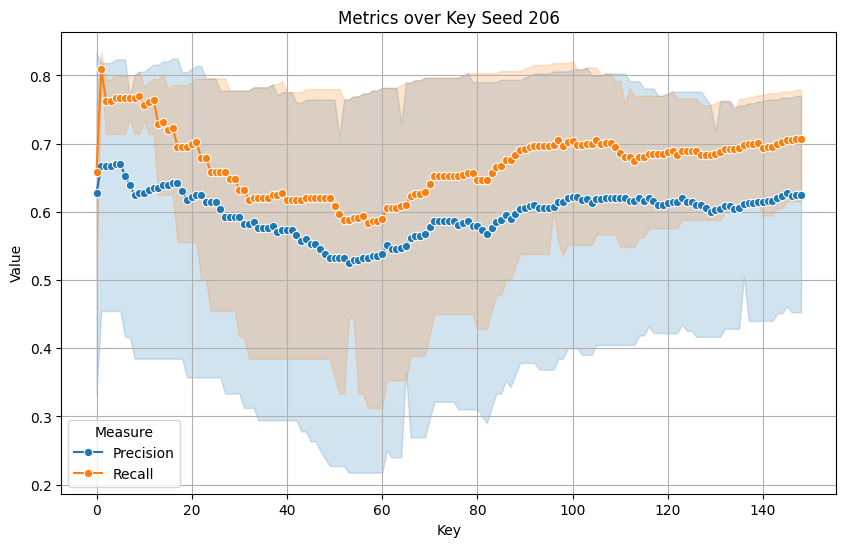

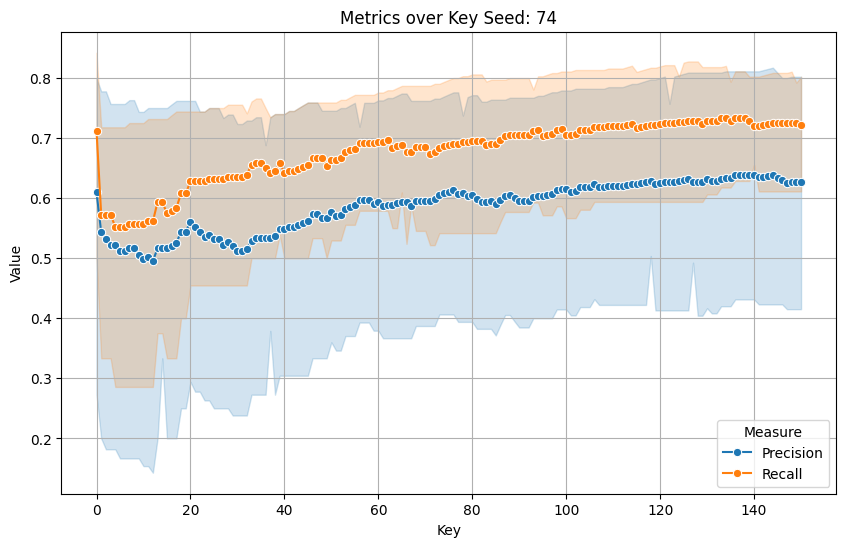

In [7]:
print("Cherrypicked results for seeds reaching a certain number of thresholds:")
print("SEED: 206")
print_iteration_number_at_threshold(saved_results[206]["iteration_number_at_threshold"])
print("SEED: 74")
print_iteration_number_at_threshold(saved_results[74]["iteration_number_at_threshold"])
visualize_metrics(saved_results[206]["gradual_metrics"], "Seed 206")
visualize_metrics(saved_results[74]["gradual_metrics"], "Seed: 74")

### Task 1.2

What is the min number of “Non-Students” to train a model that produces similar
outcome to the model trained on mixed data (from mini project 2)?

We first establish the baseline.

In [17]:
# Prepare data
RANDOM_SEED = 74 #206
random.seed(RANDOM_SEED)
verbose = False

data = pd.read_csv("../../data/answerList_data.csv")
data['TTR'] = data['Answer.explanation'].apply(calculate_ttr)
data['Worker.profession'] = data['Worker.profession'].map({'Other': 0, 'Hobbyist': 1, 'Undergraduate_Student': 2, 'Graduate_Student': 3, 'Professional_Developer':4})
data['Worker.isStudent'] = data['Worker.profession'].apply(isStudent)
data['Answer.option'] = data['Answer.option'].map({'NO': 0.0, 'IDK': 0.5, 'YES': 1.0})

# Override GroundTruth: 1 if GroundTruth == Answer.option, else 0
# Meaning 1 if the participant answered correctly in accordance with the ground truth, else 0
data["GroundTruth"] = data.apply(lambda row: 1 if row["GroundTruth"] == row["Answer.option"] else 0, axis=1)

relevant_columns=["Worker.score", "Worker.profession", "Worker.isStudent", "Answer.duration", "TTR", "Answer.confidence", 
                  "Answer.difficulty", "GroundTruth", "FailingMethod", "Answer.explanation"]

# Select relevant columns
data = data[relevant_columns]
print(data.shape)

# Balance the data
data_0 = data[data['GroundTruth'] == 0]
data_1 = data[data['GroundTruth'] == 1]
print(f"data_0: {data_0.shape[0]}\ndata_1: {data_1.shape[0]}")

if len(data_0) > len(data_1):
    data_0_balanced = data_0.sample(len(data_1), random_state=RANDOM_SEED)
    data_balanced = pd.concat([data_0_balanced, data_1])
else:
    data_1_balanced = data_1.sample(len(data_0), random_state=RANDOM_SEED)
    data_balanced = pd.concat([data_0, data_1_balanced])

data_balanced = data_balanced.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

data = data_balanced
data.groupby('GroundTruth').size()

# Get all bug report names
#failing_methods = data['FailingMethod'].unique()
failing_methods = ['HIT01_8', 'HIT02_24','HIT08_54', 'HIT05_35', 'HIT04_7', 'HIT03_6', 'HIT06_51', 'HIT07_33']

# Create holdout and training set
number_of_holdout_bug_reports = 2
#selected_failing_methods = random.sample(list(failing_methods), number_of_holdout_bug_reports)
selected_failing_methods = failing_methods[:number_of_holdout_bug_reports]
holdout_set = data[data['FailingMethod'].isin(selected_failing_methods)]
training_set = data[~data['FailingMethod'].isin(selected_failing_methods)]

print("bug reports for training set:", training_set['FailingMethod'].unique())
print("bug reports for holdout set:", holdout_set['FailingMethod'].unique())

# Split the training and holdout data into a student and a non student set
holdout_student_set = holdout_set[holdout_set['Worker.isStudent'] == 1]
holdout_non_student_set = holdout_set[holdout_set['Worker.isStudent'] == 0]
training_student_set = training_set[training_set['Worker.isStudent'] == 1]
training_non_student_set = training_set[training_set['Worker.isStudent'] == 0]

(2580, 10)
data_0: 955
data_1: 1625
bug reports for training set: ['HIT03_6' 'HIT08_54' 'HIT04_7' 'HIT06_51' 'HIT05_35' 'HIT07_33']
bug reports for holdout set: ['HIT02_24' 'HIT01_8']


#### Train a model on mixed data:

This establishes the baseline which precision and recall needs to be reached so that a model is considered to produce a "similar
outcome to the model trained on mixed data (from mini project 2)".

In [26]:
# Use Ground_Truth as the target
# We only train on the student training set
X = training_set.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
y = training_set["GroundTruth"]

# Train the model on the training set
rf_classifier = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100)
rf_classifier.fit(X, y)

# predict on the holdout set
X_holdout = holdout_set.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
y_holdout = holdout_set["GroundTruth"]
holdout_predictions = rf_classifier.predict(X_holdout)
# Calculate precision and recall on the holdout set
baseline_holdout_bug_report_metrics = bug_report_metrics(holdout_set, y_holdout, holdout_predictions, "FailingMethod")
print_bug_report_metrics(baseline_holdout_bug_report_metrics, "Holdout Set")

----------------------------------------
'Holdout Set' Metrics per Bug Report:
overall: Precision=0.66, Recall=0.75
HIT02_24: Precision=0.42, Recall=0.61
HIT01_8: Precision=0.80, Recall=0.80


In the following we gradually add more rows from the non-student training set to the student training set and train a new RF model for each. We perform predictions on the complete holdout set, to see how the model performs as the training data distribution changes.
We save the number of added non-students when various thresholds for the absolute difference between the baseline metrics and metrics for the newly trained models are reached. The number of minimum amount of non-students at various thresholds is finally reported.

In [ ]:
# We train on the student training set
X = training_student_set.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
y = training_student_set["GroundTruth"]
rf_classifier_students = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100)
rf_classifier_students.fit(X, y)

# Predict on the complete holdout set, which contains both student and non-student data
X_holdout = holdout_set.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
y_holdout = holdout_set["GroundTruth"]
holdout_predictions = rf_classifier_students.predict(X_holdout)
# Calculate precision and recall on the holdout set
holdout_bug_report_metrics = bug_report_metrics(holdout_set, y_holdout, holdout_predictions, "FailingMethod")
print_bug_report_metrics(holdout_bug_report_metrics, "Holdout Set")


# Gradually add more rows from the non-student training set to the student training set
# and train a new RF model for each. Also perform predictions on the complete holdout set to see how the model performs 
# as the training data distribution changes
interation_number = 0
gradual_metrics = {}
gradual_metrics[interation_number] = holdout_bug_report_metrics

training_non_students = training_non_student_set.copy()
training_mixed = training_student_set.copy()

iteration_number_at_threshold = {"precision": {"0.01": math.inf, "0.005": math.inf, "0.001": math.inf}, "recall": {"0.01": math.inf, "0.005": math.inf, "0.001": math.inf}}


while len(training_non_students) > 0:
    # Add a random row from the non-student training set to the student training set
    # Randomly sample a row from the non-student training set
    random_non_student_row = training_non_students.sample(n=1, random_state=RANDOM_SEED)
    # Remove the sampled row from the non-student training set
    training_non_students = training_non_students.drop(random_non_student_row.index)
    # Add the sampled row to the mixed holdout set
    training_mixed = pd.concat([training_mixed, random_non_student_row])


    X_training_mixed = training_mixed.drop(columns=["GroundTruth", "FailingMethod", "Answer.explanation"])
    y_training_mixed = training_mixed["GroundTruth"]
    bug_reports_training_mixed = training_student_set["FailingMethod"]

    # Train the model on the mixed training set
    rf_classifier_mixed = RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100)
    rf_classifier_mixed.fit(X_training_mixed, y_training_mixed)

    # Predict on the mixed holdout set
    holdout_predictions_mixed = rf_classifier_mixed.predict(X_holdout)
    # Calculate precision and recall on the holdout set
    holdout_bug_report_metrics_mixed = bug_report_metrics(holdout_set, y_holdout, holdout_predictions_mixed, "FailingMethod")

    interation_number += 1
    gradual_metrics[interation_number] = holdout_bug_report_metrics_mixed
    
    
    print(f"Training Mixed Set Size: {len(training_mixed)} | Iteration: {interation_number} | Non-Student Set Size: {len(training_non_students)}")
    if verbose:
        print_bug_report_metrics(holdout_mixed_metrics, "Holdout Mixed Set", verbose=False)

    # What is the min number of “Non-Students” to train a model that produces similar outcome to the model trained on mixed data?
    for metric in iteration_number_at_threshold.keys():
        for threshold in iteration_number_at_threshold[metric].keys():
            if abs(baseline_holdout_bug_report_metrics["overall"][metric] - holdout_bug_report_metrics_mixed["overall"][metric]) < float(threshold):
                if iteration_number_at_threshold[metric][threshold] > interation_number: # save first occurence of threshold
                    iteration_number_at_threshold[metric][threshold] = interation_number
                if verbose: print(f"{metric.capitalize()} below threshold {threshold} for iteration {interation_number} with value {holdout_bug_report_metrics_mixed["overall"][metric]:.3f}")

print_iteration_number_within_threshold(iteration_number_at_threshold)


----------------------------------------
'Holdout Set' Metrics per Bug Report:
overall: Precision=0.71, Recall=0.77
HIT02_24: Precision=0.48, Recall=0.72
HIT01_8: Precision=0.84, Recall=0.78
Training Mixed Set Size: 536 | Iteration: 1 | Non-Student Set Size: 1146
Training Mixed Set Size: 537 | Iteration: 2 | Non-Student Set Size: 1145
Training Mixed Set Size: 538 | Iteration: 3 | Non-Student Set Size: 1144
Training Mixed Set Size: 539 | Iteration: 4 | Non-Student Set Size: 1143
Training Mixed Set Size: 540 | Iteration: 5 | Non-Student Set Size: 1142
Training Mixed Set Size: 541 | Iteration: 6 | Non-Student Set Size: 1141
Training Mixed Set Size: 542 | Iteration: 7 | Non-Student Set Size: 1140
Training Mixed Set Size: 543 | Iteration: 8 | Non-Student Set Size: 1139
Training Mixed Set Size: 544 | Iteration: 9 | Non-Student Set Size: 1138
Training Mixed Set Size: 545 | Iteration: 10 | Non-Student Set Size: 1137
Training Mixed Set Size: 546 | Iteration: 11 | Non-Student Set Size: 1136
Trai

In [33]:
print_iteration_number_within_threshold(iteration_number_at_threshold)

----------------------------------------
Number of 'Non-Students' added to the 'Student Training Set' before
Precision is within 0.01 absolute difference to baseline: 8
Precision is within 0.005 absolute difference to baseline: 8
Precision is within 0.001 absolute difference to baseline: 12
Recall is within 0.01 absolute difference to baseline: 30
Recall is within 0.005 absolute difference to baseline: 106
Recall is within 0.001 absolute difference to baseline: 106


The minimum amount of non-students that need to be added to the 'Student Training Set' before precision and recall are within the following thresholds to the baseline precision and recall is

| Precision Threshold | Amount   |
|-----------|-------|
| 0.01      | 8     |
| 0.005     | 8     |
| 0.001     | 12    |


| Recall Threshold | Amount |
|-----------|-------|
| 0.01      | 30    |
| 0.005     | 106   |
| 0.001     | 106   |

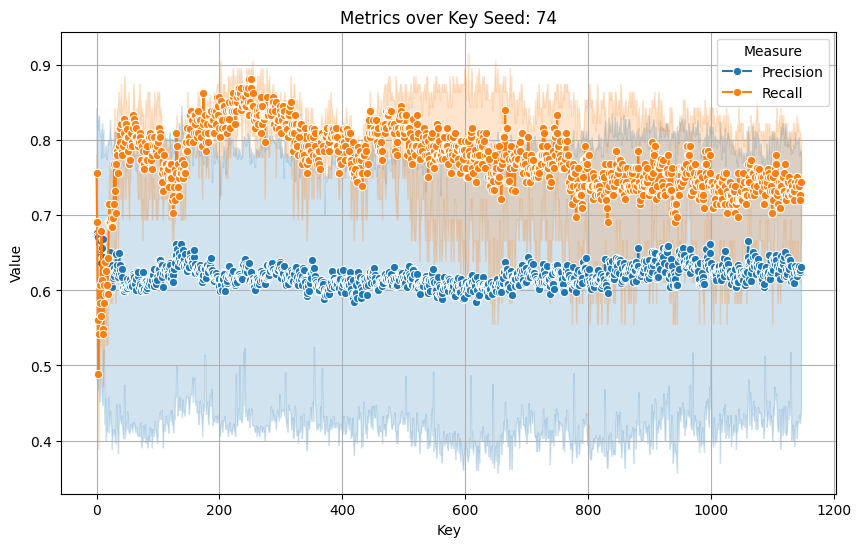

In [16]:
visualize_metrics(gradual_metrics, "Seed: " + str(RANDOM_SEED))